In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.graph_objects as go
import itertools
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
import matplotlib.patches as mpatches
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
import os

# Montar Google Drive
drive.mount('/content/drive')

# Cambiar al directorio donde se encuentra el dataset
dataset_path = '/content/drive/My Drive/ESPECIALITZACIÓ/IA/PROYECTOS/Proyecto2/Elementos'
os.listdir(dataset_path)  # Verifica los archivos en el directorio

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['readme.md',
 'Lexique - Data Analyst.xlsx',
 'extract - cash request - data analyst.csv',
 'extract - fees - data analyst - .csv',
 'extract - cash request - data analyst.gsheet',
 'extract - fees - data analyst - .gsheet']

In [ ]:
# Cargar el dataset principal de solicitudes de adelanto en efectivo
credit_requests = pd.read_csv('/content/drive/MyDrive/ESPECIALITZACIÓ/IA/PROYECTOS/Proyecto2/Elementos/extract - cash request - data analyst.csv')
# Crear una copia del DataFrame para preservar el original
cr = credit_requests.copy()

# Cargar el dataset de tarifas o fees para análisis de cohortes de tarifas
fees = pd.read_csv('/content/drive/MyDrive/ESPECIALITZACIÓ/IA/PROYECTOS/Proyecto2/Elementos/extract - fees - data analyst - .csv')
# Crear una copia del DataFrame para preservar el original
fs = fees.copy()

In [ ]:
# Filtrar columnas relevantes para el análisis
cr = cr[["amount", "created_at", "user_id", "deleted_account_id", "transfer_type"]]
cr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23970 entries, 0 to 23969
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   amount              23970 non-null  float64
 1   created_at          23970 non-null  object 
 2   user_id             21867 non-null  float64
 3   deleted_account_id  2104 non-null   float64
 4   transfer_type       23970 non-null  object 
dtypes: float64(3), object(2)
memory usage: 936.5+ KB


In [ ]:
# Rellenar valores nulos en 'user_id' usando 'deleted_account_id' (clientes transferidos de cuentas eliminadas)
cr.fillna({"user_id": cr["deleted_account_id"]}, inplace=True)

In [ ]:
# Eliminar la columna 'deleted_account_id' ya que no es necesaria después de la imputación
cr.drop(columns=["deleted_account_id"], inplace=True)
cr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23970 entries, 0 to 23969
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   amount         23970 non-null  float64
 1   created_at     23970 non-null  object 
 2   user_id        23970 non-null  float64
 3   transfer_type  23970 non-null  object 
dtypes: float64(2), object(2)
memory usage: 749.2+ KB


In [ ]:
# Convertir 'created_at' a tipo datetime para manipulación de fechas
cr['created_at'] = pd.to_datetime(cr['created_at'])
cr.head()

# Convertir la columna 'created_at' en fees a tipo datetime para análisis temporal
fs['created_at'] = pd.to_datetime(fs['created_at'])
fs.head()

,id,cash_request_id,type,status,category,total_amount,reason,created_at,updated_at,paid_at,from_date,to_date,charge_moment
0,6537,14941.0,instant_payment,rejected,NaN,5.0,Instant Payment Cash Request 14941,2020-09-07 10:47:27.423150+00:00,2020-10-13 14:25:09.396112+00,2020-12-17 14:50:07.47011+00,NaN,NaN,after
1,6961,11714.0,incident,accepted,rejected_direct_debit,5.0,rejected direct debit,2020-09-09 20:51:17.998653+00:00,2020-10-13 14:25:15.537063+00,2020-12-08 17:13:10.45908+00,NaN,NaN,after
2,16296,23371.0,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 23371,2020-10-23 10:10:58.352972+00:00,2020-10-23 10:10:58.352994+00,2020-11-04 19:34:37.43291+00,NaN,NaN,after
3,20775,26772.0,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 26772,2020-10-31 15:46:53.643958+00:00,2020-10-31 15:46:53.643982+00,2020-11-19 05:09:22.500223+00,NaN,NaN,after
4,11242,19350.0,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 19350,2020-10-06 08:20:17.170432+00:00,2020-10-13 14:25:03.267983+00,2020-11-02 14:45:20.355598+00,NaN,NaN,after


In [ ]:
# Convertir la columna 'created_at' a una fecha sin zona horaria
cr['created_at'] = cr['created_at'].dt.tz_localize(None)
cr.head()

,amount,created_at,user_id,transfer_type
0,100.0,2019-12-10 19:05:21.596873,804.0,regular
1,100.0,2019-12-10 19:50:12.347780,231.0,regular
2,100.0,2019-12-10 19:13:35.825460,191.0,regular
3,99.0,2019-12-10 19:16:10.880172,761.0,regular
4,100.0,2020-05-06 09:59:38.877376,7686.0,regular


In [ ]:
# Crear columna 'Mes' indicando el mes de cada solicitud
cr['Mes'] = cr['created_at'].dt.to_period('M')
cr.head()

,amount,created_at,user_id,transfer_type,Mes
0,100.0,2019-12-10 19:05:21.596873,804.0,regular,2019-12
1,100.0,2019-12-10 19:50:12.347780,231.0,regular,2019-12
2,100.0,2019-12-10 19:13:35.825460,191.0,regular,2019-12
3,99.0,2019-12-10 19:16:10.880172,761.0,regular,2019-12
4,100.0,2020-05-06 09:59:38.877376,7686.0,regular,2020-05


In [ ]:
# Crear columna 'Cohorte' que indica el mes de la primera solicitud de cada cliente
cr['Cohorte'] = cr.groupby('user_id')['created_at'].transform('min').dt.to_period('M')
cr.head(10)

,amount,created_at,user_id,transfer_type,Mes,Cohorte
0,100.0,2019-12-10 19:05:21.596873,804.0,regular,2019-12,2019-12
1,100.0,2019-12-10 19:50:12.347780,231.0,regular,2019-12,2019-12
2,100.0,2019-12-10 19:13:35.825460,191.0,regular,2019-12,2019-12
3,99.0,2019-12-10 19:16:10.880172,761.0,regular,2019-12,2019-12
4,100.0,2020-05-06 09:59:38.877376,7686.0,regular,2020-05,2020-05
5,100.0,2020-05-23 20:58:55.129432,9489.0,regular,2020-05,2020-05
6,100.0,2020-06-16 17:07:38.452652,14631.0,regular,2020-06,2020-06
7,100.0,2020-02-10 01:11:53.808270,309.0,regular,2020-02,2020-01
8,100.0,2020-06-28 12:06:33.712840,2499.0,regular,2020-06,2020-06
9,90.0,2019-12-10 19:51:23.911206,897.0,regular,2019-12,2019-12


In [ ]:
# Calcular el número inicial de clientes únicos en cada cohorte
cohort_sizes_initial = cr.groupby('Cohorte').agg(Num_Clientes_Iniciales=('user_id', 'nunique')).reset_index()
cohort_sizes_initial

,Cohorte,Num_Clientes_Iniciales
0,2019-11,1
1,2019-12,254
2,2020-01,106
3,2020-02,90
4,2020-03,86
5,2020-04,246
6,2020-05,432
7,2020-06,1540
8,2020-07,1482
9,2020-08,728


In [ ]:
# Calcular la cantidad de clientes únicos en cada cohorte para cada mes
cohort_sizes_monthly = cr.groupby(['Cohorte', 'Mes']).agg(Num_Clientes=('user_id', 'nunique')).reset_index()
cohort_sizes_monthly

,Cohorte,Mes,Num_Clientes
0,2019-11,2019-11,1
1,2019-11,2019-12,1
2,2019-11,2020-04,1
3,2019-11,2020-05,1
4,2019-11,2020-08,1
...,...,...,...
78,2020-09,2020-10,680
79,2020-09,2020-11,20
80,2020-10,2020-10,4802
81,2020-10,2020-11,15


In [ ]:
# Calcular la cantidad de solicitudes de adelanto de efectivo de los clientes de cada cohorte en cada mes
cohort_cash_monthly = cr.groupby(['Cohorte', 'Mes']).agg(Num_Solicitudes=('user_id', 'count')).reset_index()
cohort_cash_monthly

,Cohorte,Mes,Num_Solicitudes
0,2019-11,2019-11,1
1,2019-11,2019-12,1
2,2019-11,2020-04,1
3,2019-11,2020-05,1
4,2019-11,2020-08,1
...,...,...,...
78,2020-09,2020-10,727
79,2020-09,2020-11,20
80,2020-10,2020-10,5043
81,2020-10,2020-11,15


In [ ]:
# Calcular la tasa de retención de clientes (clientes únicos por cohorte en cada mes / clientes iniciales de la cohorte)
retention_clientes = cohort_sizes_monthly.pivot(index='Cohorte', columns='Mes', values='Num_Clientes')
retention_clientes = retention_clientes.div(cohort_sizes_initial.set_index('Cohorte')['Num_Clientes_Iniciales'], axis=0)
retention_clientes

Mes,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11
Cohorte,,,,,,,,,,,,,
2019-11,1.0,1.0,NaN,NaN,NaN,1.000000,1.000000,NaN,NaN,1.000000,1.000000,1.000000,NaN
2019-12,NaN,1.0,0.354331,0.228346,0.267717,0.263780,0.295276,0.287402,0.232283,0.263780,0.169291,0.244094,0.003937
2020-01,NaN,NaN,1.000000,0.207547,0.150943,0.254717,0.254717,0.254717,0.264151,0.198113,0.188679,0.226415,0.009434
2020-02,NaN,NaN,NaN,1.000000,0.500000,0.466667,0.466667,0.433333,0.433333,0.400000,0.277778,0.377778,NaN
2020-03,NaN,NaN,NaN,NaN,1.000000,0.441860,0.430233,0.523256,0.418605,0.395349,0.337209,0.313953,0.011628
2020-04,NaN,NaN,NaN,NaN,NaN,1.000000,0.471545,0.495935,0.373984,0.325203,0.308943,0.247967,NaN
2020-05,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.590278,0.506944,0.430556,0.340278,0.356481,0.009259
2020-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.490909,0.482468,0.372727,0.367532,0.003247
2020-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.474359,0.344804,0.359649,0.004723


In [ ]:
# Agregar columnas de temporalidad
# Semana y mes de la solicitud
cr['Semana_Mes'] = cr['created_at'].dt.strftime('%U_%B') + '_' + cr['Mes'].dt.strftime('%Y')
# Día y semana de la solicitud
cr['Dia_Semana'] = cr['created_at'].dt.strftime('%A') + '_' + cr['Semana_Mes']
# Hora y dia de la solicitud
cr['Hora_Dia'] = cr['created_at'].dt.hour.astype(str) + '_' + cr['Dia_Semana']
cr.head()


,amount,created_at,user_id,transfer_type,Mes,Cohorte,Semana_Mes,Dia_Semana,Hora_Dia
0,100.0,2019-12-10 19:05:21.596873,804.0,regular,2019-12,2019-12,49_December_2019,Tuesday_49_December_2019,19_Tuesday_49_December_2019
1,100.0,2019-12-10 19:50:12.347780,231.0,regular,2019-12,2019-12,49_December_2019,Tuesday_49_December_2019,19_Tuesday_49_December_2019
2,100.0,2019-12-10 19:13:35.825460,191.0,regular,2019-12,2019-12,49_December_2019,Tuesday_49_December_2019,19_Tuesday_49_December_2019
3,99.0,2019-12-10 19:16:10.880172,761.0,regular,2019-12,2019-12,49_December_2019,Tuesday_49_December_2019,19_Tuesday_49_December_2019
4,100.0,2020-05-06 09:59:38.877376,7686.0,regular,2020-05,2020-05,18_May_2020,Wednesday_18_May_2020,9_Wednesday_18_May_2020


In [ ]:
# Calcular la cantidad de adelanto de efectivo por cohorte y mes
cohort_revenue = cr.groupby(['Cohorte', 'Mes'])['amount'].sum().reset_index()
cohort_revenue = cohort_revenue.pivot(index='Cohorte', columns='Mes', values='amount')
cohort_revenue

Mes,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11
Cohorte,,,,,,,,,,,,,
2019-11,1.0,100.0,NaN,NaN,NaN,100.0,10.0,NaN,NaN,10.0,5.0,6.0,NaN
2019-12,NaN,27197.0,10123.0,5881.0,7650.0,7900.0,8175.0,8805.0,6990.0,7790.0,4860.0,6655.0,100.0
2020-01,NaN,NaN,11464.0,2360.0,1660.0,3500.0,3020.0,2770.0,3010.0,2150.0,1970.0,2350.0,100.0
2020-02,NaN,NaN,NaN,8412.0,4740.0,4607.0,4350.0,4235.0,4405.0,4130.0,2555.0,3595.0,NaN
2020-03,NaN,NaN,NaN,NaN,9499.0,4250.0,4540.0,4850.0,4055.0,3390.0,2800.0,2700.0,50.0
2020-04,NaN,NaN,NaN,NaN,NaN,25736.0,14258.0,14320.0,11000.0,9915.0,7685.0,6450.0,NaN
2020-05,NaN,NaN,NaN,NaN,NaN,NaN,44883.0,30143.0,25725.0,21224.0,16350.0,15305.0,350.0
2020-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180903.0,92672.0,84491.0,60025.0,56525.0,400.0
2020-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180330.0,76873.0,49725.0,47313.0,500.0


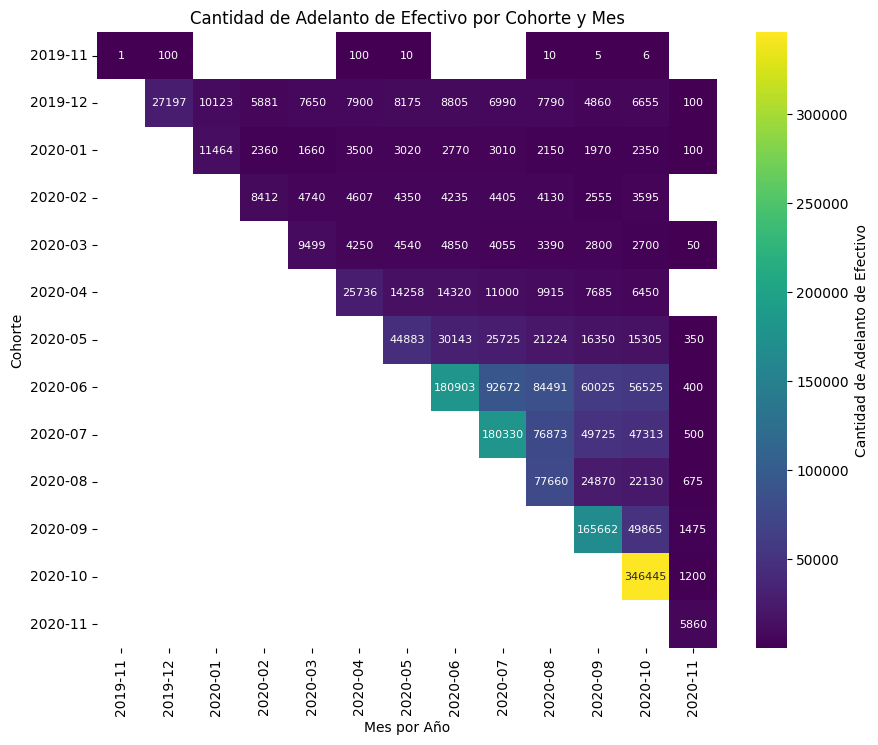

In [ ]:
# Graficar la cantidad de adelanto de efectivo por cohorte y mes
plt.figure(figsize=(10, 8))
plt.title('Cantidad de Adelanto de Efectivo por Cohorte y Mes')
sns.heatmap(data=cohort_revenue, annot=True, fmt='.0f', cmap='viridis', annot_kws={"size": 8}, cbar_kws={'label': 'Cantidad de Adelanto de Efectivo'})
plt.xlabel('Mes por Año')
plt.ylabel('Cohorte')
plt.show()

In [ ]:
# Crear DataFrame de cohortes para el mes de '2020-03'
cohort_amount_2020_03 = cr[cr['Cohorte'] == '2020-03'].groupby('user_id')['amount'].sum().reset_index()
cohort_amount_2020_03

,user_id,amount
0,161.0,400.0
1,400.0,800.0
2,447.0,100.0
3,448.0,80.0
4,475.0,100.0
...,...,...
81,13975.0,650.0
82,14798.0,650.0
83,16345.0,400.0
84,21228.0,200.0


In [ ]:
# Ordenar por el monto total para encontrar los 10 usuarios principales
sort_cohort_amount_2020_03 = cohort_amount_2020_03.sort_values(by='amount', ascending=False)
top_10_users = sort_cohort_amount_2020_03.head(10)
top_10_users

,user_id,amount
36,3377.0,1305.0
52,4297.0,1200.0
45,3617.0,1000.0
50,3948.0,950.0
20,2548.0,900.0
43,3557.0,900.0
9,680.0,850.0
77,4715.0,800.0
1,400.0,800.0
6,496.0,750.0


In [ ]:
# Filtrar para incluir solo los 10 usuarios seleccionados
amount_2020_03 = cr[cr['Cohorte'] == '2020-03'].groupby(['user_id', 'Mes'])['amount'].sum().reset_index()
cohort_amount_2020_03_top10 = amount_2020_03[amount_2020_03['user_id'].isin(top_10_users['user_id'])]
cohort_amount_2020_03_top10 = cohort_amount_2020_03_top10.pivot(index='user_id', columns='Mes', values='amount')
cohort_amount_2020_03_top10

Mes,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11
user_id,,,,,,,,,
400.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,NaN
496.0,150.0,NaN,100.0,100.0,100.0,100.0,100.0,100.0,NaN
680.0,200.0,100.0,100.0,100.0,100.0,100.0,100.0,50.0,NaN
2548.0,100.0,100.0,100.0,100.0,100.0,200.0,NaN,200.0,NaN
3377.0,300.0,150.0,270.0,200.0,185.0,100.0,50.0,NaN,50.0
3557.0,200.0,200.0,NaN,200.0,200.0,100.0,NaN,NaN,NaN
3617.0,200.0,NaN,200.0,100.0,200.0,100.0,100.0,100.0,NaN
3948.0,200.0,200.0,200.0,100.0,NaN,100.0,NaN,150.0,NaN
4297.0,200.0,200.0,200.0,200.0,200.0,100.0,100.0,NaN,NaN


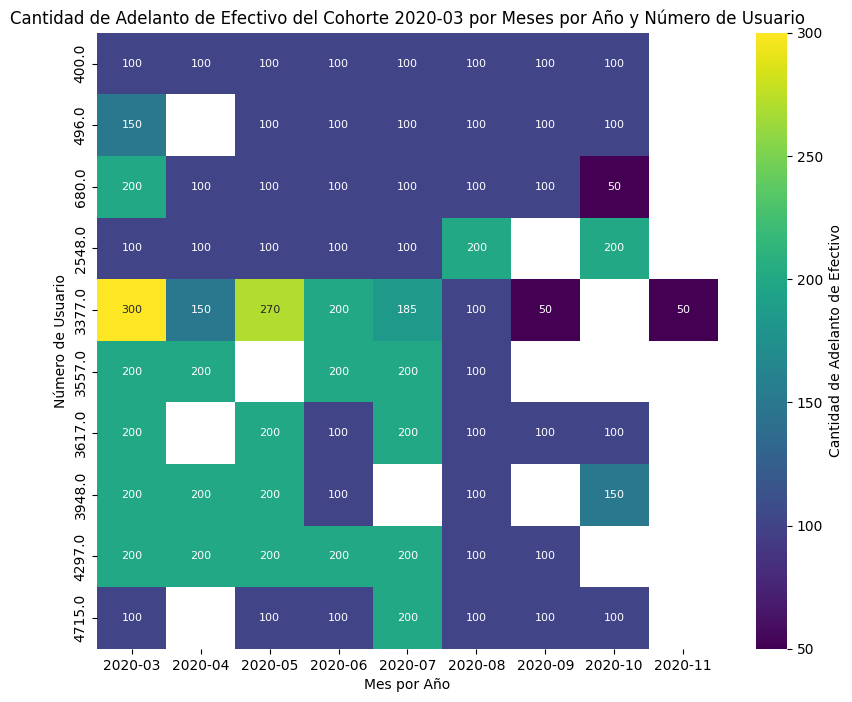

In [ ]:
# Graficar la cantidad de adelanto de efectivo de un cohorte por meses y número de usuarios
plt.figure(figsize=(10, 8))
plt.title('Cantidad de Adelanto de Efectivo del Cohorte 2020-03 por Meses por Año y Número de Usuario')
sns.heatmap(data=cohort_amount_2020_03_top10, annot=True, fmt='.0f', cmap='viridis', annot_kws={"size": 8}, cbar_kws={'label': 'Cantidad de Adelanto de Efectivo'})
plt.xlabel('Mes por Año')
plt.ylabel('Número de Usuario')
plt.show()

In [ ]:
# Filtrar para calcular la cantidad de adelanto de efectivo por cohorte y semana
cohort_weekly_amount = cr[cr['Cohorte'] == '2020-03'].groupby(['user_id', 'Semana_Mes'])['amount'].sum().reset_index()
cohort_weekly_amount

,user_id,Semana_Mes,amount
0,161.0,09_March_2020,100.0
1,161.0,14_April_2020,100.0
2,161.0,19_May_2020,100.0
3,161.0,23_June_2020,100.0
4,400.0,10_March_2020,100.0
...,...,...,...
362,16345.0,31_August_2020,100.0
363,16345.0,36_September_2020,100.0
364,21228.0,13_March_2020,100.0
365,21228.0,32_August_2020,100.0


In [ ]:
 # Filtrar para incluir solo los 10 usuarios seleccionados
cohort_weekly_amount_top10 = cohort_weekly_amount[cohort_weekly_amount['user_id'].isin(top_10_users['user_id'])]
cohort_weekly_amount_top10 = cohort_weekly_amount_top10.pivot(index='user_id', columns='Semana_Mes', values='amount')
cohort_weekly_amount_top10

Semana_Mes,09_March_2020,10_March_2020,11_March_2020,12_March_2020,13_April_2020,14_April_2020,15_April_2020,16_April_2020,18_May_2020,19_May_2020,...,33_August_2020,34_August_2020,35_August_2020,35_September_2020,36_September_2020,37_September_2020,40_October_2020,41_October_2020,43_October_2020,44_November_2020
user_id,,,,,,,,,,,,,,,,,,,,,
400.0,NaN,100.0,NaN,NaN,NaN,100.0,NaN,NaN,100.0,NaN,...,NaN,NaN,NaN,NaN,NaN,100.0,100.0,NaN,NaN,NaN
496.0,NaN,100.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,100.0,NaN,NaN,100.0,NaN,NaN
680.0,100.0,NaN,100.0,NaN,NaN,100.0,NaN,NaN,NaN,100.0,...,NaN,NaN,NaN,100.0,NaN,NaN,50.0,NaN,NaN,NaN
2548.0,100.0,NaN,NaN,NaN,NaN,NaN,100.0,NaN,100.0,NaN,...,NaN,NaN,100.0,NaN,NaN,NaN,100.0,NaN,100.0,NaN
3377.0,NaN,100.0,100.0,100.0,50.0,NaN,NaN,100.0,100.0,50.0,...,NaN,NaN,NaN,50.0,NaN,NaN,NaN,NaN,NaN,50.0
3557.0,NaN,200.0,NaN,NaN,NaN,200.0,NaN,NaN,NaN,NaN,...,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3617.0,200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,100.0,NaN,NaN,NaN,100.0,NaN,NaN
3948.0,NaN,NaN,100.0,100.0,100.0,NaN,NaN,100.0,NaN,100.0,...,NaN,100.0,NaN,NaN,NaN,NaN,50.0,NaN,100.0,NaN
4297.0,NaN,NaN,200.0,NaN,200.0,NaN,NaN,NaN,NaN,200.0,...,NaN,NaN,NaN,NaN,NaN,100.0,NaN,NaN,NaN,NaN


In [ ]:
# Seleccionar las primeras 10 semanas
cohort_weekly_amount_top10 = cohort_weekly_amount_top10.loc[:, cohort_weekly_amount_top10.columns[:10]]
cohort_weekly_amount_top10

Semana_Mes,09_March_2020,10_March_2020,11_March_2020,12_March_2020,13_April_2020,14_April_2020,15_April_2020,16_April_2020,18_May_2020,19_May_2020
user_id,,,,,,,,,,
400.0,NaN,100.0,NaN,NaN,NaN,100.0,NaN,NaN,100.0,NaN
496.0,NaN,100.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
680.0,100.0,NaN,100.0,NaN,NaN,100.0,NaN,NaN,NaN,100.0
2548.0,100.0,NaN,NaN,NaN,NaN,NaN,100.0,NaN,100.0,NaN
3377.0,NaN,100.0,100.0,100.0,50.0,NaN,NaN,100.0,100.0,50.0
3557.0,NaN,200.0,NaN,NaN,NaN,200.0,NaN,NaN,NaN,NaN
3617.0,200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3948.0,NaN,NaN,100.0,100.0,100.0,NaN,NaN,100.0,NaN,100.0
4297.0,NaN,NaN,200.0,NaN,200.0,NaN,NaN,NaN,NaN,200.0


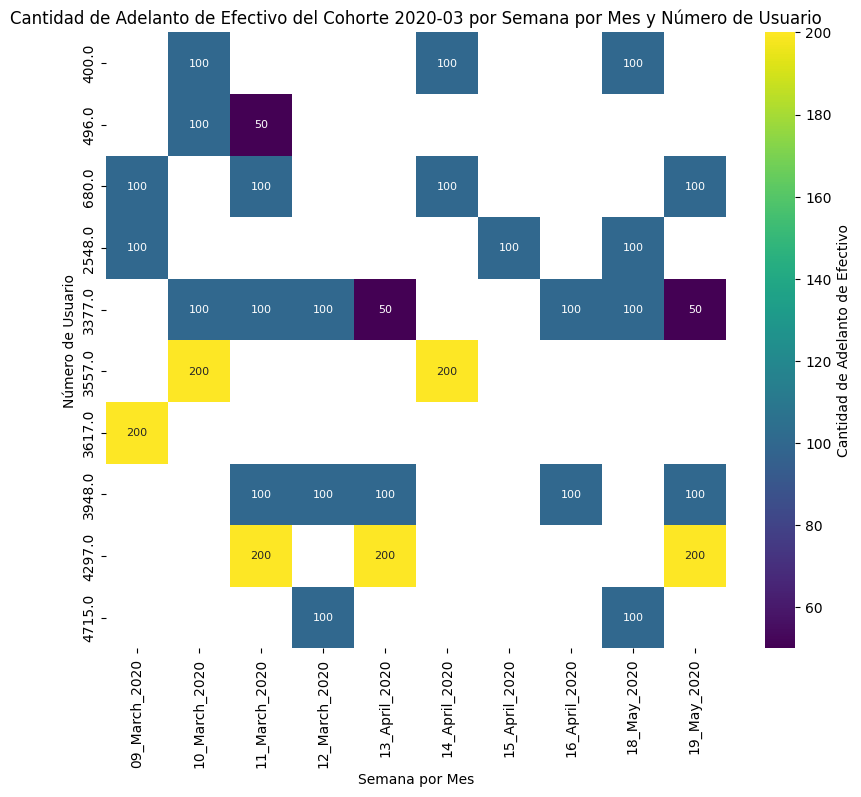

In [ ]:
 # Graficar la cantidad de adelanto de efectivo de los 10 principales usuarios por semana
plt.figure(figsize=(10, 8))
plt.title('Cantidad de Adelanto de Efectivo del Cohorte 2020-03 por Semana por Mes y Número de Usuario')
sns.heatmap(data=cohort_weekly_amount_top10, annot=True, fmt='.0f', cmap='viridis', annot_kws={"size": 8}, cbar_kws={'label': 'Cantidad de Adelanto de Efectivo'})
plt.xlabel('Semana por Mes')
plt.ylabel('Número de Usuario')
plt.show()

# PREDICCION CON ACUMULADO (RETO CLASSE) 2019-12 DE COHORTE HACER PREDICCIÓN

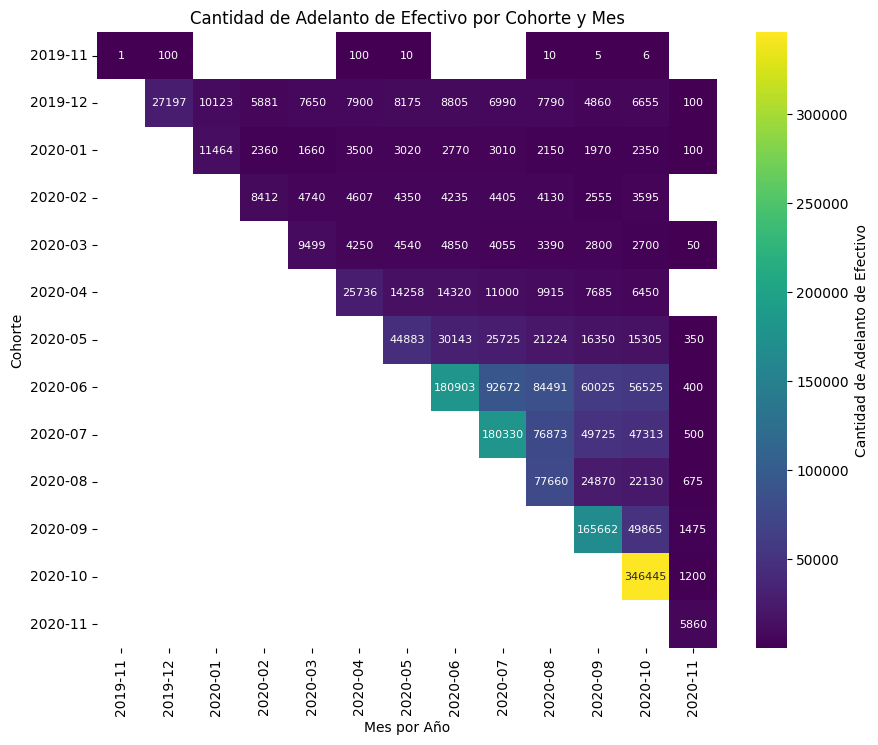

In [ ]:
# Graficar la cantidad de adelanto de efectivo por cohorte y mes
plt.figure(figsize=(10, 8))
plt.title('Cantidad de Adelanto de Efectivo por Cohorte y Mes')
sns.heatmap(data=cohort_revenue, annot=True, fmt='.0f', cmap='viridis', annot_kws={"size": 8}, cbar_kws={'label': 'Cantidad de Adelanto de Efectivo'})
plt.xlabel('Mes por Año')
plt.ylabel('Cohorte')
plt.show()

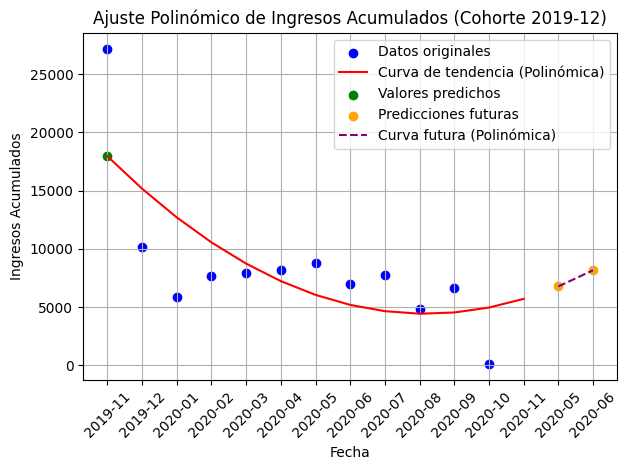

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Supongamos que los datos de ingresos por cohorte y mes ya están calculados como `cohort_revenue`
# Ahora, seleccionamos los datos de la cohorte 2019-12 (como ejemplo)
cohorte_2019_12 = cohort_revenue.loc['2019-12']

# Crear un DataFrame con los valores no nulos
datos_no_nulos = cohorte_2019_12.dropna()
x_no_nulos = np.array(range(len(datos_no_nulos))).reshape(-1, 1)
y_no_nulos = datos_no_nulos.values

# Transformar los datos para ajustar un modelo polinómico de grado 2
poly = PolynomialFeatures(degree=2)
x_poly = poly.fit_transform(x_no_nulos)

# Crear el modelo de regresión lineal sobre los datos transformados
modelo = LinearRegression()
modelo.fit(x_poly, y_no_nulos)

# Predecir los valores faltantes (antes de 2020-04)
total_fechas = len(cohorte_2019_12.index)
fechas_completas = np.array(range(total_fechas)).reshape(-1, 1)
fechas_completas_poly = poly.transform(fechas_completas)
predicciones_completas = modelo.predict(fechas_completas_poly)

# Predecir los valores para fechas futuras (2020-05, 2020-06)
fechas_futuras = np.array([total_fechas, total_fechas + 1]).reshape(-1, 1)
fechas_futuras_poly = poly.transform(fechas_futuras)
predicciones_futuras = modelo.predict(fechas_futuras_poly)

# Graficar los datos originales (sin los NULOS)
plt.scatter(x_no_nulos, y_no_nulos, label='Datos originales', color='blue')

# Graficar la curva de tendencia (ajuste polinómico)
plt.plot(fechas_completas, predicciones_completas, color='red', label='Curva de tendencia (Polinómica)')

# Graficar los valores predichos (faltantes)
faltantes_indices = np.where(cohorte_2019_12.isna())[0]
plt.scatter(faltantes_indices, predicciones_completas[faltantes_indices], color='green', label='Valores predichos')

# Graficar las predicciones futuras
fechas_futuras_etiquetas = ['2020-05', '2020-06']
plt.scatter(fechas_futuras, predicciones_futuras, color='orange', label='Predicciones futuras')
plt.plot(fechas_futuras, predicciones_futuras, color='purple', linestyle='--', label='Curva futura (Polinómica)')

# Configurar las etiquetas del eje X con las fechas
fechas_reales = list(cohorte_2019_12.index) + fechas_futuras_etiquetas
plt.xticks(ticks=range(len(fechas_reales)), labels=fechas_reales, rotation=45)

# Configuración del gráfico
plt.xlabel('Fecha')
plt.ylabel('Ingresos Acumulados')
plt.title('Ajuste Polinómico de Ingresos Acumulados (Cohorte 2019-12)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
# Calcular la tasa de retención de clientes (clientes únicos por cohorte en cada mes / clientes iniciales de la cohorte)
retention_clientes = cohort_sizes_monthly.pivot(index='Cohorte', columns='Mes', values='Num_Clientes')
retention_clientes = retention_clientes.div(cohort_sizes_initial.set_index('Cohorte')['Num_Clientes_Iniciales'], axis=0)
retention_clientes


# Agregar columnas de temporalidad
# Semana y mes de la solicitud
cr['Semana_Mes'] = cr['created_at'].dt.strftime('%U_%B') + '_' + cr['Mes'].dt.strftime('%Y')
# Día y semana de la solicitud
cr['Dia_Semana'] = cr['created_at'].dt.strftime('%A') + '_' + cr['Semana_Mes']
# Hora y dia de la solicitud
cr['Hora_Dia'] = cr['created_at'].dt.hour.astype(str) + '_' + cr['Dia_Semana']
cr.head()


# Calcular la cantidad de adelanto de efectivo por cohorte y mes
cohort_revenue = cr.groupby(['Cohorte', 'Mes'])['amount'].sum().reset_index()
cohort_revenue = cohort_revenue.pivot(index='Cohorte', columns='Mes', values='amount')

# Calcular los ingresos acumulados por cohorte y mes
cohort_revenue_acumulado = cohort_revenue.cumsum(axis=1)

# Mostrar los ingresos acumulados
cohort_revenue_acumulado

Mes,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11
Cohorte,,,,,,,,,,,,,
2019-11,1.0,101.0,NaN,NaN,NaN,201.0,211.0,NaN,NaN,221.0,226.0,232.0,NaN
2019-12,NaN,27197.0,37320.0,43201.0,50851.0,58751.0,66926.0,75731.0,82721.0,90511.0,95371.0,102026.0,102126.0
2020-01,NaN,NaN,11464.0,13824.0,15484.0,18984.0,22004.0,24774.0,27784.0,29934.0,31904.0,34254.0,34354.0
2020-02,NaN,NaN,NaN,8412.0,13152.0,17759.0,22109.0,26344.0,30749.0,34879.0,37434.0,41029.0,NaN
2020-03,NaN,NaN,NaN,NaN,9499.0,13749.0,18289.0,23139.0,27194.0,30584.0,33384.0,36084.0,36134.0
2020-04,NaN,NaN,NaN,NaN,NaN,25736.0,39994.0,54314.0,65314.0,75229.0,82914.0,89364.0,NaN
2020-05,NaN,NaN,NaN,NaN,NaN,NaN,44883.0,75026.0,100751.0,121975.0,138325.0,153630.0,153980.0
2020-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180903.0,273575.0,358066.0,418091.0,474616.0,475016.0
2020-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180330.0,257203.0,306928.0,354241.0,354741.0


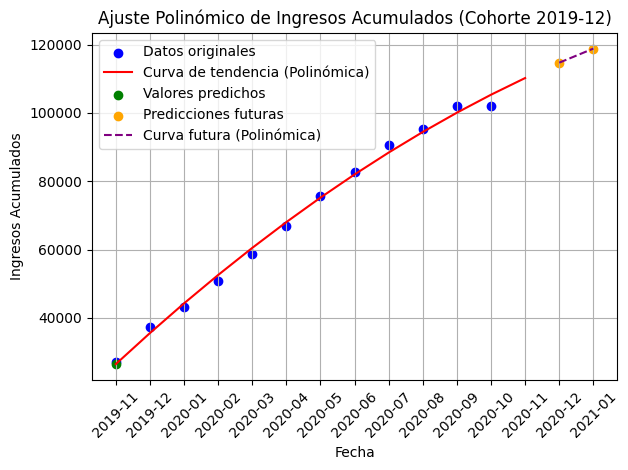

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Supongamos que ahora tienes los ingresos acumulados por cohorte y mes en `cohort_revenue_acumulado`
# Seleccionamos los datos de la cohorte 2019-12 (como ejemplo)
cohorte_2019_12 = cohort_revenue_acumulado.loc['2019-12']

# Crear un DataFrame con los valores no nulos
datos_no_nulos = cohorte_2019_12.dropna()
x_no_nulos = np.array(range(len(datos_no_nulos))).reshape(-1, 1)
y_no_nulos = datos_no_nulos.values

# Transformar los datos para ajustar un modelo polinómico de grado 2
poly = PolynomialFeatures(degree=2)
x_poly = poly.fit_transform(x_no_nulos)

# Crear el modelo de regresión lineal sobre los datos transformados
modelo = LinearRegression()
modelo.fit(x_poly, y_no_nulos)

# Predecir los valores faltantes (antes de 2020-04)
total_fechas = len(cohorte_2019_12.index)
fechas_completas = np.array(range(total_fechas)).reshape(-1, 1)
fechas_completas_poly = poly.transform(fechas_completas)
predicciones_completas = modelo.predict(fechas_completas_poly)

# Predecir los valores para fechas futuras (2020-12, 2021-01)
fechas_futuras = np.array([total_fechas, total_fechas + 1]).reshape(-1, 1)
fechas_futuras_poly = poly.transform(fechas_futuras)
predicciones_futuras = modelo.predict(fechas_futuras_poly)

# Graficar los datos originales (sin los NULOS)
plt.scatter(x_no_nulos, y_no_nulos, label='Datos originales', color='blue')

# Graficar la curva de tendencia (ajuste polinómico)
plt.plot(fechas_completas, predicciones_completas, color='red', label='Curva de tendencia (Polinómica)')

# Graficar los valores predichos (faltantes)
faltantes_indices = np.where(cohorte_2019_12.isna())[0]
plt.scatter(faltantes_indices, predicciones_completas[faltantes_indices], color='green', label='Valores predichos')

# Graficar las predicciones futuras
fechas_futuras_etiquetas = ['2020-12', '2021-01']
plt.scatter(fechas_futuras, predicciones_futuras, color='orange', label='Predicciones futuras')
plt.plot(fechas_futuras, predicciones_futuras, color='purple', linestyle='--', label='Curva futura (Polinómica)')

# Configurar las etiquetas del eje X con las fechas
fechas_reales = list(cohorte_2019_12.index) + fechas_futuras_etiquetas
plt.xticks(ticks=range(len(fechas_reales)), labels=fechas_reales, rotation=45)

# Configuración del gráfico
plt.xlabel('Fecha')
plt.ylabel('Ingresos Acumulados')
plt.title('Ajuste Polinómico de Ingresos Acumulados (Cohorte 2019-12)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# **MODELO 2**

Interpolacion 80, extrapolacion 20

Precisión del modelo en datos de prueba: 0.9953


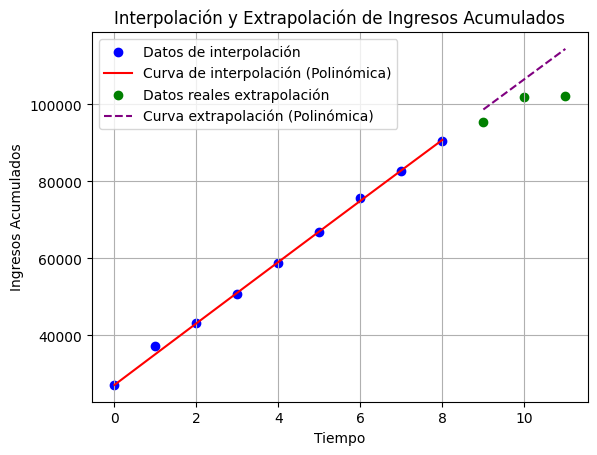

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Supongamos que ahora tienes los ingresos acumulados por cohorte y mes en `cohort_revenue_acumulado`
# Seleccionamos los datos de la cohorte 2019-12 (como ejemplo)
cohorte_2019_12 = cohort_revenue_acumulado.loc['2019-12']

# Crear un DataFrame con los valores no nulos
datos_no_nulos = cohorte_2019_12.dropna()
n_total = len(datos_no_nulos)

# División de los datos
n_interpolacion = int(n_total * 0.8)
n_extrapolacion = n_total - n_interpolacion

# Datos para interpolación (80%)
datos_interpolacion = datos_no_nulos.iloc[:n_interpolacion]
x_interpolacion = np.array(range(len(datos_interpolacion))).reshape(-1, 1)
y_interpolacion = datos_interpolacion.values

# División en entrenamiento (80%) y prueba (20%)
x_train, x_test, y_train, y_test = train_test_split(x_interpolacion, y_interpolacion, test_size=0.2, random_state=42)

# Datos para extrapolación (20%)
datos_extrapolacion = datos_no_nulos.iloc[n_interpolacion:]
x_extrapolacion = np.array(range(n_interpolacion, n_total)).reshape(-1, 1)
y_extrapolacion = datos_extrapolacion.values

# Transformar los datos para ajustar un modelo polinómico de grado 2
poly = PolynomialFeatures(degree=2)
x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.transform(x_test)

# Crear el modelo de regresión polinómica y entrenarlo
modelo = LinearRegression()
modelo.fit(x_train_poly, y_train)

# Evaluar el modelo
score = modelo.score(x_test_poly, y_test)
print(f'Precisión del modelo en datos de prueba: {score:.4f}')

# Predicciones en el conjunto completo de interpolación
x_interpolacion_poly = poly.transform(x_interpolacion)
predicciones_interpolacion = modelo.predict(x_interpolacion_poly)

# Predicciones para extrapolación
x_extrapolacion_poly = poly.transform(x_extrapolacion)
predicciones_extrapolacion = modelo.predict(x_extrapolacion_poly)

# Graficar los datos originales de interpolación
plt.scatter(x_interpolacion, y_interpolacion, label='Datos de interpolación', color='blue')
plt.plot(x_interpolacion, predicciones_interpolacion, color='red', label='Curva de interpolación (Polinómica)')

# Graficar los datos de extrapolación
plt.scatter(x_extrapolacion, y_extrapolacion, label='Datos reales extrapolación', color='green')
plt.plot(x_extrapolacion, predicciones_extrapolacion, color='purple', linestyle='--', label='Curva extrapolación (Polinómica)')

# Configuración del gráfico
plt.xlabel('Tiempo')
plt.ylabel('Ingresos Acumulados')
plt.title('Interpolación y Extrapolación de Ingresos Acumulados')
plt.legend()
plt.grid()
plt.show()

## **New Model**

Precisión del modelo en datos de prueba: 0.9944


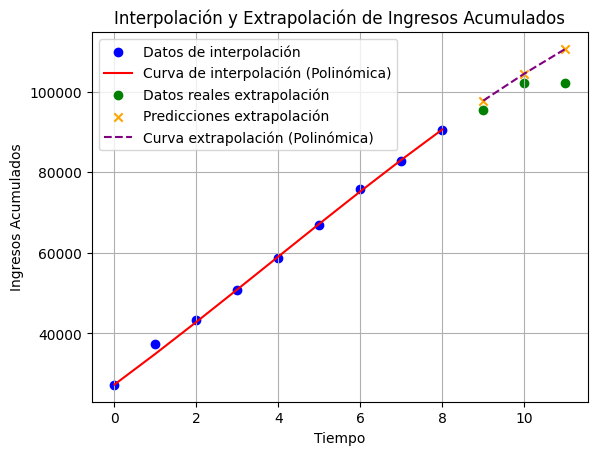

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Supongamos que ahora tienes los ingresos acumulados por cohorte y mes en `cohort_revenue_acumulado`
# Seleccionamos los datos de la cohorte 2019-12 (como ejemplo)
cohorte_2019_12 = cohort_revenue_acumulado.loc['2019-12']

# Crear un DataFrame con los valores no nulos
datos_no_nulos = cohorte_2019_12.dropna()
n_total = len(datos_no_nulos)

# División de los datos
n_interpolacion = int(n_total * 0.8)
n_extrapolacion = n_total - n_interpolacion

# Datos para interpolación (80%)
datos_interpolacion = datos_no_nulos.iloc[:n_interpolacion]
x_interpolacion = np.array(range(len(datos_interpolacion))).reshape(-1, 1)
y_interpolacion = datos_interpolacion.values

# División en entrenamiento (80%) y prueba (20%)
x_train, x_test, y_train, y_test = train_test_split(x_interpolacion, y_interpolacion, test_size=0.2, random_state=42)

# Datos para extrapolación (20%)
datos_extrapolacion = datos_no_nulos.iloc[n_interpolacion:]
x_extrapolacion = np.array(range(n_interpolacion, n_total)).reshape(-1, 1)
y_extrapolacion = datos_extrapolacion.values

# Transformar los datos para ajustar un modelo polinómico de grado 3
poly = PolynomialFeatures(degree=3)
x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.transform(x_test)

# Crear el modelo de regresión polinómica y entrenarlo
modelo = LinearRegression()
modelo.fit(x_train_poly, y_train)

# Evaluar el modelo
score = modelo.score(x_test_poly, y_test)
print(f'Precisión del modelo en datos de prueba: {score:.4f}')

# Predicciones en el conjunto completo de interpolación
x_interpolacion_poly = poly.transform(x_interpolacion)
predicciones_interpolacion = modelo.predict(x_interpolacion_poly)

# Predicciones para extrapolación
x_extrapolacion_poly = poly.transform(x_extrapolacion)
predicciones_extrapolacion = modelo.predict(x_extrapolacion_poly)

# Graficar los datos originales de interpolación
plt.scatter(x_interpolacion, y_interpolacion, label='Datos de interpolación', color='blue')
plt.plot(x_interpolacion, predicciones_interpolacion, color='red', label='Curva de interpolación (Polinómica)')

# Graficar los datos de extrapolación reales y predichos
plt.scatter(x_extrapolacion, y_extrapolacion, label='Datos reales extrapolación', color='green')
plt.scatter(x_extrapolacion, predicciones_extrapolacion, label='Predicciones extrapolación', color='orange', marker='x')
plt.plot(x_extrapolacion, predicciones_extrapolacion, color='purple', linestyle='--', label='Curva extrapolación (Polinómica)')

# Configuración del gráfico
plt.xlabel('Tiempo')
plt.ylabel('Ingresos Acumulados')
plt.title('Interpolación y Extrapolación de Ingresos Acumulados')
plt.legend()
plt.grid()
plt.show()